In [ ]:
import torch, numpy as np, seaborn as sb, torchvision.transforms.functional as TF
import matplotlib.pyplot as plt, matplotlib as mpl
from torch import nn,tensor
from fastcore.utils import *
from k_diffusion import *
from einops import rearrange
from torchvision import datasets#, transforms, utils
from torch.utils import data

torch.manual_seed(42)
mpl.rcParams['image.cmap'] = 'gray_r'
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [ ]:
from miniai.datasets import *

In [ ]:
model_path = Path('outputs/mse-no-temb_00060000.pth')
sz = 28
sigma_min,sigma_max,sigma_data = 1e-2,80,0.6162
bs = 16

In [ ]:
def tf(image):
    h, w = image.size
    image = np.array(image, dtype=np.float32)[..., None] / 255
    image = torch.as_tensor(image).movedim(2, 0) * 2 - 1
    return image

In [ ]:
# def tf(image): return TF.to_tensor(image)[...]*2-1

In [ ]:
train_set = datasets.FashionMNIST('data', train=True, download=True, transform=tf)
train_set[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_dl = data.DataLoader(train_set, bs, shuffle=True, drop_last=True, num_workers=4)
x,y = next(iter(train_dl))
x.shape

torch.Size([16, 1, 28, 28])

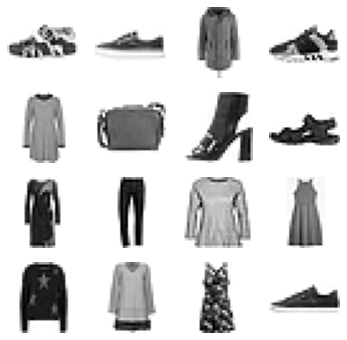

In [ ]:
show_images(x, imsize=1.5)

In [ ]:
n = len(x)
sigmas = torch.rand(n)*2
sigmas

tensor([0.78, 1.20, 0.51, 1.59, 1.88, 0.27, 1.87, 1.19, 1.74, 1.14, 1.48, 0.86, 1.77, 1.15, 0.53, 1.25])

In [ ]:
def rbroadcast(x, t): return x.reshape(x.shape + (1,)*(t.ndim-x.ndim))

In [ ]:
noise = torch.randn(n,1,sz,sz)
noised = x+noise*rbroadcast(sigmas,noise)

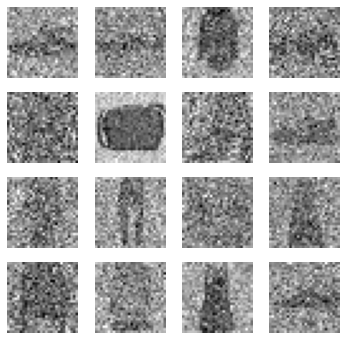

In [ ]:
show_images(noised, imsize=1.5)

In [ ]:
model = models.ImageDenoiserModelV1(
    c_in=1, feats_in=256, depths=[2,4,4], channels=[64,128,256], self_attn_depths=[False, False, True],
    cross_attn_depths=None, patch_size=1, dropout_rate=0.05, mapping_cond_dim=9, unet_cond_dim=0,
    cross_cond_dim=0, skip_stages=0, has_variance=False).cuda()

chkpt = torch.load(model_path)['model_ema']
nn.modules.utils.consume_prefix_in_state_dict_if_present(chkpt, 'inner_model.')
model.load_state_dict(chkpt)

<All keys matched successfully>

In [ ]:
model = Denoiser(model).cuda()
out = model(noised.cuda(), tensor(1.).cuda()).data.cpu()

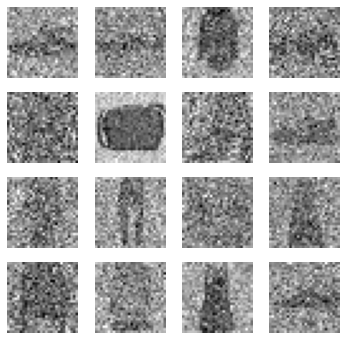

In [ ]:
show_images(noised, imsize=1.5)

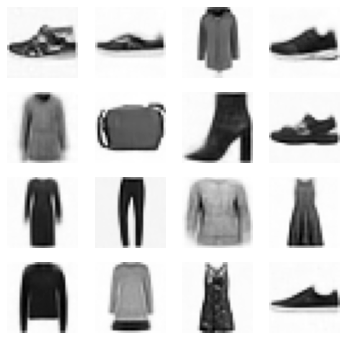

In [ ]:
show_images(out, imsize=1.5)

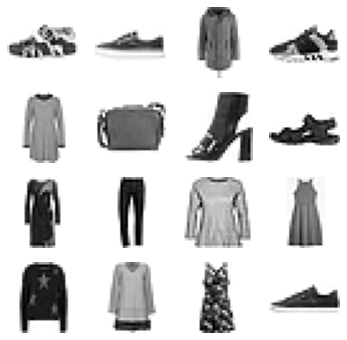

In [ ]:
show_images(x, imsize=1.5)

In [ ]:
sigmas = sampling.get_sigmas_karras(20, sigma_min, sigma_max, rho=7.)
sigmas

tensor([   80.00,    60.97,    45.97,    34.24,    25.18,    18.26,    13.04,     9.15,     6.30,     4.25,     2.80,     1.80,     1.12,
            0.67,     0.39,     0.21,     0.11,     0.05,     0.02,     0.01,     0.00])

In [ ]:
torch.manual_seed(42)
xr = torch.randn([8, 1, sz, sz]).cuda() * sigma_max
x_0 = sampling.sample_heun(model, xr.cuda(), sigmas.cuda()).data.cpu()

  0%|          | 0/20 [00:00<?, ?it/s]

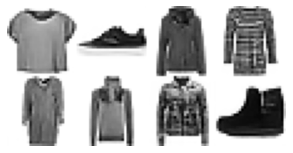

In [ ]:
x = (x_0.clamp(-1,1)+1)/2
x = rearrange(x, '(b1 b2) c h w -> (b1 h) (b2 w) c ', b2=4)
plt.figure(figsize=(5,5))
plt.imshow(x, cmap='gray_r')
plt.axis('off');

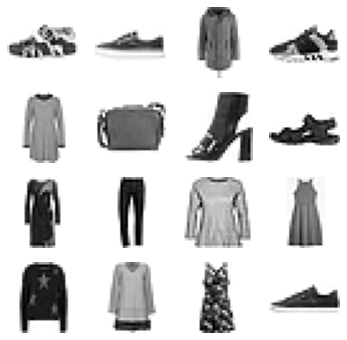

In [ ]:
show_images(x, imsize=1.5)

In [ ]:
loc,scale = -1.2,1.2
density = partial(utils.rand_log_normal, loc=loc, scale=scale)

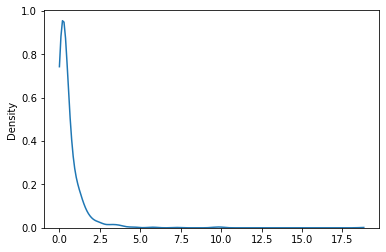

In [ ]:
sb.kdeplot(density(1000), cut=0);

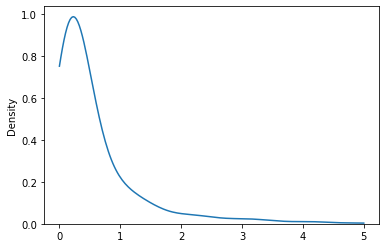

In [ ]:
sb.kdeplot(density(1000), clip=(0,5));